# Dependeces

In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

   
    #!mkdir -p ../checkpoints/
    #!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-18feeqpy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-18feeqpy
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-cp311-cp311-linux_x86_64.whl size=542007 sha256=db005d5b9e3908c5cd8c4abc9b27ce0e00d456a6d68ad441b1dab40f936b5f03
  Stored in directory: /tmp/pip-ephem-wheel-cache-30yt01iw/wheels/d8/63/41/d37b316a85599f58a42be0210805ecf8594b9c06082028716e
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0
--202

# Setup

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

# Load Model

In [6]:
%ls ..

checkpoints/  inference/


### Troca de Modelos

In [16]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

#sam2_checkpoint = "../checkpoints/sam-img-complete/checkpoint.pt"  # modelo imagens completas
sam2_checkpoint = "../checkpoints/sam-img-crop/checkpoint.pt"       # modelo imagens recortadas
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [22]:
import os
import random
from PIL import Image
import numpy as np

#image_folder = 'DATASET-V1-4/test'     # dataset imagens completas
image_folder = 'DATASET-V1-5/test'      # dataset imagens recortadas

image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
random_image_file = random.choice(image_files)
image = Image.open(os.path.join(image_folder, random_image_file))
image = np.array(image.convert("RGB"))


In [23]:
masks = mask_generator.generate(image)

In [24]:
print(len(masks))
print(masks[0].keys())

1
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


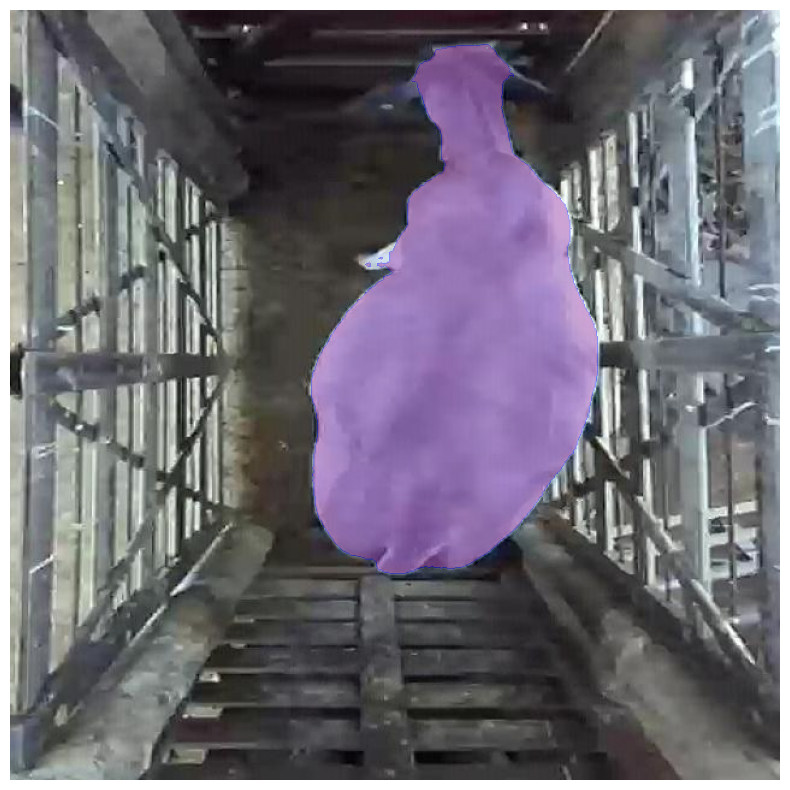

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

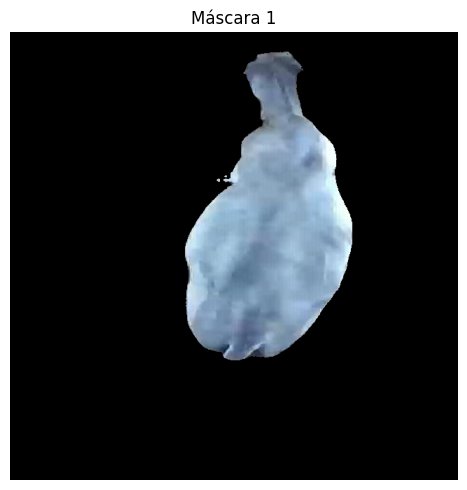

In [26]:
masks_list = [mask['segmentation'] for mask in masks]  # Lista de máscaras

# Mostra as máscaras separadas
num_masks = len(masks_list)
plt.figure(figsize=(10, 5 * num_masks))

for i, mask in enumerate(masks_list):
    isolated_mask = np.zeros_like(image)
    isolated_mask[mask] = image[mask]  # Aplica a máscara na imagem original

    plt.subplot(num_masks, 1, i + 1)
    plt.title(f"Máscara {i + 1}")
    plt.imshow(isolated_mask)
    plt.axis("off")

plt.tight_layout()
plt.show()
